In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Lendo Dados
df = pd.read_csv('../data/insurance.csv')

#Transformando Váriaveis Categóricas em Numéricas
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)
df['smoker'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
df['region'] = df['region'].apply(lambda x: 0 if x == 'southwest' else 1 if x == 'southeast' else 2 if x == 'northwest' else 3)

In [127]:
#Função para calcular o erro percentual médio - Métrica de Avaliação
'''def erro_percentual_medio_pessoa(Y_true, Y_pred):
    erro = 0
    for i in range(len(Y_true)):
        erro += (Y_pred[i]- Y_true.values[i][0])/Y_true.values[i][0]
    return erro/len(Y_true)
'''
#Função para calcular a diferença total naquele teste - Métrica de Avaliação
def diferenca_grupo(Y_true, Y_pred):
    perda = 0
    for i in range(len(Y_true)):
        perda += Y_pred[i]- Y_true.values[i][0]
    return perda

#Função para calcular o diferença percentual - Métrica de Avaliação
def diferenca_percentual_grupo(Y_true, Y_pred):
    perda = 0
    for i in range(len(Y_true)):
        perda += (Y_pred[i]- Y_true.values[i][0])
    return perda/sum(Y_true.values)


#Função Para Gerar Histograma dos Erros
def grafico(diferencas_por_grupo,diferencas_percentuais_por_grupo):
    fig,ax = plt.subplots(2,1,figsize=(10,10))
    #erros = np.array(erros_percentuais_medios_por_pessoa)
    diffs = np.array(diferencas_por_grupo)
    diffs_p = np.array(diferencas_percentuais_por_grupo)
    
    sns.histplot(diffs,color='#17726d',ax=ax[0])
    ax[0].axvline(np.mean(diffs),color='#a0c2a9',label=f'Média: {(np.mean(diffs)).round(2)}',linestyle='--')
    ax[0].legend(loc='upper right')
    ax[0].set_xlabel('Erro')
    ax[0].set_ylabel('Frequência')
    ax[0].set_title('Histograma de Média de Erro Total Por Teste(400 amostras) - 100 Testes')
    
    sns.histplot(diffs_p,color='#17726d',ax=ax[1])
    ax[1].axvline(np.mean(diffs_p),color='#a0c2a9',label=f'Média: {((np.mean(diffs_p))*100).round(2)}%',linestyle='--')
    ax[1].legend(loc='upper right')
    ax[1].set_xlabel('Erro')
    ax[1].set_ylabel('Frequência')
    ax[1].set_title('Histograma de Média de Erro Percentual Por Teste(400 amostras) - 100 Testes')
    '''
    sns.histplot(erros,color='#17726d')
    ax[2].axvline(np.mean(erros),color='#a0c2a9',label=f'Média: {((np.mean(diffs_p))*100).round(2)}%',linestyle='--')
    ax[2].legend(loc='upper right')
    ax[2].set_xlabel('Erro')
    ax[2].set_ylabel('Frequência')
    ax[2].set_title('Histograma de Média de Erro Percentual Por Pessoa Por Teste - 100 Testes')
    '''
    plt.show()

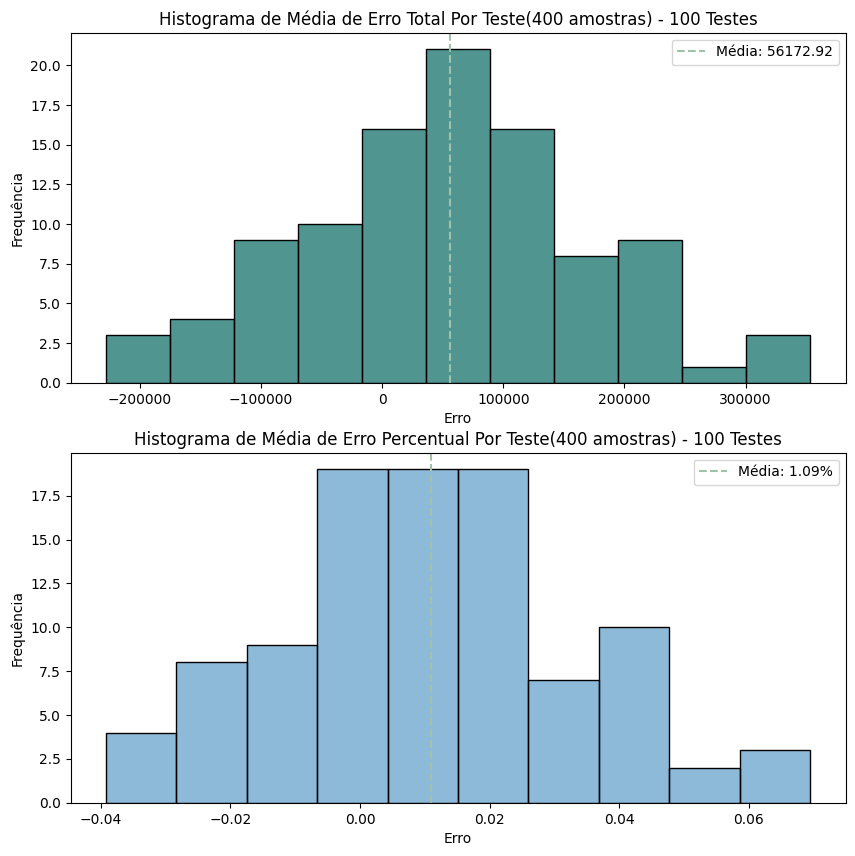

In [128]:
#XGBoost Padrão
erros_percentuais_medios_por_pessoa = [] #Lista para armazenar os erros de cada teste
diferencas_grupo = []
diferencas_percentuais_grupo = []
for i in range(100):
    #Separando os dados de treino(70%) e teste(30%) aleatoriamente a cada iteração
    X_train,X_test,Y_train,Y_true = train_test_split(df[['age','sex','bmi','children','smoker','region']],df[['charges']],test_size=0.3,random_state=i)
    #Criando Modelo
    model = xgb.XGBRegressor(max_depth=6, #Profundidade Máxima da Árvore (Número de Nós)
                             learning_rate=0.1, #Taxa de aprendizado
                             n_estimators=100 #Número de árvores
                             )
    model.fit(X_train,Y_train) #Treinando o Modelo
    Y_pred = model.predict(X_test) #Realizando Previsões
    #erros_percentuais_medios_por_pessoa.append(erro_percentual_medio_pessoa(Y_true,Y_pred)) #Adicionando Métrica de Erro ao vetor de erros
    diferencas_grupo.append(diferenca_grupo(Y_true,Y_pred)) #Adicionando Métrica de Perda ao vetor de perdas
    diferencas_percentuais_grupo.append(diferenca_percentual_grupo(Y_true,Y_pred)) #Adicionando Métrica de 
#Gerar Histograma dos Erros
grafico(diferencas_grupo,diferencas_percentuais_grupo)

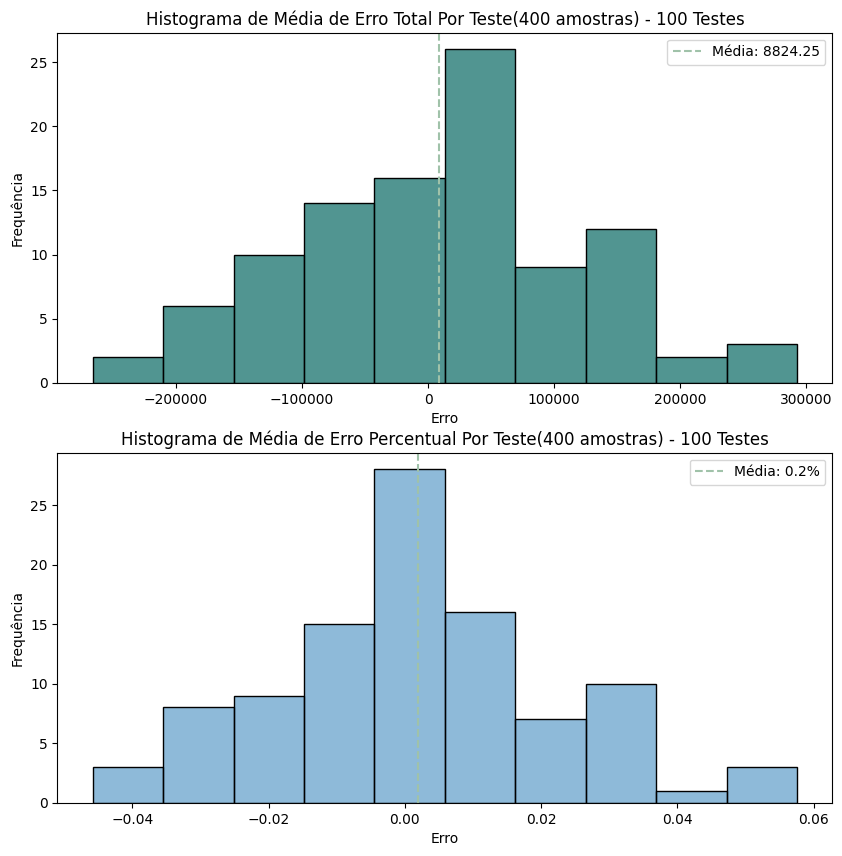

In [129]:
#XGBoost - Reduzir SuperEstimação
def loss_melhorada(predt,dtrain):
    y = dtrain.get_label()
    erro = predt-y
    grad= 2 * (predt-y)
    hess= 2 * np.ones_like(y) 
    coeficiente_penalizacao = 1.4
    return np.where(erro>0,[grad*coeficiente_penalizacao,hess*coeficiente_penalizacao],[grad,hess])

#erros = []
diffs = [] 
diffs_p = []
for i in range(100):
    #Separando os dados de treino(70%) e teste(30%) aleatoriamente a cada iteração
    X_train,X_test,Y_train,Y_true = train_test_split(df[['age','sex','bmi','children','smoker','region']],df[['charges']],test_size=0.3,random_state=i)
    #Criando Matriz de Dados
    dtrain = xgb.DMatrix(X_train,label=Y_train)
    #Criando Modelo
    model = xgb.train({'tree_method': 'hist','max_depth':6,'learning_rate':0.1},  # any other tree method is fine.
            dtrain=dtrain,
            num_boost_round=100,
            obj=loss_melhorada
           )
    dtest = xgb.DMatrix(X_test)
    Y_pred = model.predict(dtest) #Realizando Previsões
    #erros.append(erro_percentual_medio_pessoa(Y_true,Y_pred)) #Adicionando Métrica de Erro ao vetor de erros
    diffs.append(diferenca_grupo(Y_true,Y_pred)) #Adicionando Métrica de Perda ao vetor de perdas
    diffs_p.append(diferenca_percentual_grupo(Y_true,Y_pred)) #Adicionando Métrica 
grafico(diffs,diffs_p)

In [ ]:
#Carregando Modelo e Gerando Previsões 
modelo_ultiomo_teste = xgb.XGBRegressor()
modelo_ultiomo_teste.load_model('model.json')
#Realizqr Previsão em Novo Conjunto de Teste
X_train,X_test,Y_train,Y_true = train_test_split(df[['age','sex','bmi','children','smoker','region']],df[['charges']],test_size=0.3,random_state=100)
Y_pred = modelo_ultiomo_teste.predict(X_test)
#Salvando em Arquivo Excel
df_resultado = pd.DataFrame({'Previsões':Y_pred})
df_resultado.rename_axis('ID',inplace=True)
df_resultado.to_excel('previsoes.xlsx',index=True)